TO DO:
- supervised ce? 
- replicate w/ twitter dfs? 
- try different types of scoring in logreg? different test sizes?
- export model and reuse w/ predictions (use additions to test against base set)  

In [1]:
#imports + path
import pandas as pd
import json
import re
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas_profiling import ProfileReport
path = '/Users/laurentfintoni/Desktop/University/COURSE DOCS/THESIS/Internship/musow-pipeline/'

Part 1: 
- create DFs for trainin set using musoW and MJI spreadsheets
- two versions: a base one and one w/ additions from ismir dataset (for musoW) and from additional research (for MJI)
- the baseline difference we want to train the LogReg model on is that musoW is focused on music archives w/ datasets while MJI is focused on all sorts of music archives, regardless of dataset inclusion
- to avoid polluting the two sets we check for duplicates at all possible stages to ensure that the MJI set does not have anything that currently exists in musoW 

In [2]:
#read mji csv and grab needed columns
df_mji = pd.read_csv(path+'MJI/MJI_data.csv', keep_default_na=False, dtype='string')
df_mji_small = pd.DataFrame(columns=['Title', 'Description', 'URL'])
df_mji_small['Title'] = df_mji['Title'].str.lower().str.strip()
df_mji_small['Description'] = df_mji['Description'].str.lower().str.strip()
df_mji_small['URL'] = df_mji['URL'].str.lower().str.strip()

In [3]:
#read musow json dump and grab needed columns
with open(path+'MUSOW/musow_name_desc_url_cat.json') as file:
    data = json.load(file)
    
musow_names = [result['name']['value'].strip().lower() for result in data['results']['bindings']]
musow_desc = [result['description']['value'].strip().lower() for result in data['results']['bindings']]
musow_url = [result['url']['value'].strip().lower() for result in data['results']['bindings']]
df_musow = pd.DataFrame(columns=['Title', 'Description', 'URL'])
df_musow['Title'] = musow_names
df_musow['Description'] = musow_desc
df_musow['URL'] = musow_url
df_musow = df_musow.astype('string')

In [4]:
#remove musow duplicates from MJI set 
mji_training_set = df_mji_small[~df_mji_small['Title'].isin(df_musow['Title'])].dropna()

In [5]:
#create positive and negative sets w/o additions, add target column 
positive_df = df_musow.copy()
positive_df['Target'] = '1'
negative_df = mji_training_set.copy()
negative_df['Target'] = '0'

In [6]:
#create positive and negative sets w/ additions, add target column 
ismir_df = pd.read_pickle(path+'GH_PICKLES/ismir.pkl')
ismir_df = ismir_df[~ismir_df['Title'].isin(df_musow['Title'])].dropna() 
positive_df_adds = pd.concat([df_musow, ismir_df]).reset_index(drop=True)
positive_df_adds = positive_df_adds.drop_duplicates(['Title'], keep='last')
positive_df_adds['Target'] = '1'
mji_additions_1 = pd.read_csv(path+'MJI/MJI_additions_for_LR.csv')
mji_additions_1['Title'] = mji_additions_1['Title'].str.lower().str.strip()
mji_additions_1['Description'] = mji_additions_1['Description'].str.lower().str.strip()
mji_additions_1['URL'] = mji_additions_1['URL'].str.lower().str.strip()
mji_additions_1 = mji_additions_1[~mji_additions_1['Title'].isin(df_musow['Title'])].dropna()
mji_additions_1 = mji_additions_1[~mji_additions_1['Title'].isin(mji_training_set['Title'])].dropna()
negative_df_adds = pd.concat([mji_training_set, mji_additions_1]).reset_index(drop=True)
negative_df_adds = negative_df_adds.drop_duplicates(['Title'], keep='last')
negative_df_adds['Target'] = '0'

In [7]:
#merge both sets into one, create two training sets one base, one extended w/ additional data, pickle for reuse
training_set = pd.concat([positive_df, negative_df])
training_set['Target'] = training_set['Target'].astype('int')
training_set = training_set.reset_index(drop=True)
training_set_adds = pd.concat([positive_df_adds, negative_df_adds])
training_set_adds['Target'] = training_set_adds['Target'].astype('int')
training_set_adds = training_set_adds.reset_index(drop=True)
training_set.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset.pkl')
training_set_adds.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended.pkl')

In [8]:
#combine three feature column into one, create new DFs, pickle for reuse

training_set_xtra = training_set.copy()
training_set_adds_xtra = training_set_adds.copy()

#create combined columns for desc+headline and desc+headline_url
def tokenize_url(url:str):
    url=url.replace("https","")
    url=url.replace("http","")
    url=url.replace("www","")   
    url=re.sub("(\W|_)+"," ",url)
    return url

#create tokenized URL field
training_set_xtra['tokenized_url']=training_set_xtra['URL'].apply(lambda x:tokenize_url(x))
#description + tokenized url
training_set_xtra['text_desc_headline_url'] = training_set_xtra['Description'] + ' '+ training_set_xtra['Title']+" " + training_set_xtra['tokenized_url']
training_set_xtra.drop(['tokenized_url', 'Title', 'Description', 'URL'], inplace=True, axis=1)

#create tokenized URL field
training_set_adds_xtra['tokenized_url']=training_set_adds_xtra['URL'].apply(lambda x:tokenize_url(x))
#description + tokenized url
training_set_adds_xtra['text_desc_headline_url'] = training_set_adds_xtra['Description'] + ' '+ training_set_adds_xtra['Title']+" " + training_set_adds_xtra['tokenized_url']
training_set_adds_xtra.drop(['tokenized_url', 'Title', 'Description', 'URL'], inplace=True, axis=1)

training_set_xtra.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_xtracols.pkl')
training_set_adds_xtra.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_xtracols.pkl')

In [9]:
#print some base stats to keep track of changes: training set size, avg length of description (main feature)

print('Size of base set:', len(training_set.index), '\nMedian length of description in base set is:', training_set['Description'].str.len().median(), '\nMean length of description in base set is:', training_set['Description'].str.len().mean(), '\nSize of extended set:', len(training_set_adds.index), '\nMedian length of description in extended set is:', training_set_adds['Description'].str.len().median(), '\nMean length of description in extended set is:', training_set_adds['Description'].str.len().mean())

#print some base stats to keep track of changes: avg length of combined desc+title+url (main feature)

print('\nMedian length of description in base set w/ xtra cols is:', training_set_xtra['text_desc_headline_url'].str.len().median(), '\nMean length of description in base set w/ xtra cols is:', training_set_xtra['text_desc_headline_url'].str.len().mean(), '\nMedian length of description in extended set w/ xtra cols is:', training_set_adds_xtra['text_desc_headline_url'].str.len().median(), '\nMean length of description in extended set w/ xtra cols is:', training_set_adds_xtra['text_desc_headline_url'].str.len().mean())

Size of base set: 626 
Median length of description in base set is: 291.0 
Mean length of description in base set is: 343.55271565495207 
Size of extended set: 781 
Median length of description in extended set is: 355.0 
Mean length of description in extended set is: 535.2394366197183

Median length of description in base set w/ xtra cols is: 360.5 
Mean length of description in base set w/ xtra cols is: 408.073482428115 
Median length of description in extended set w/ xtra cols is: 419.0 
Mean length of description in extended set w/ xtra cols is: 601.8143405889884


Part 2:
- Try different unsupervised encoding approaches for categorical variables including OrdinalEncoder, Label Encoding, Tf-Idf, BackwardDifferenceEncoder 
- Ordinal and Label encoding use title, desc, and url + combined title/desc and title/desc/url as features depending on source version of training set
- BackwardDifference uses title, desc, and url + separated title/desc and title/desc/url as features (in order to see if there's any diff btw the two different combination of strings approach)
- Tf-Idf uses only desc, title/desc, and title/desc/url as features 

In [10]:
#encode categorial variables w/ OrdinalEncoder, pickle
ord_enc = OrdinalEncoder()

#base set 
training_set_ordinal = training_set.copy()
training_set_ordinal["Title_encoded"] = ord_enc.fit_transform(training_set_ordinal[["Title"]])
training_set_ordinal["Desc_encoded"] = ord_enc.fit_transform(training_set_ordinal[["Description"]])
training_set_ordinal["URL_encoded"] = ord_enc.fit_transform(training_set_ordinal[["URL"]])
training_set_ordinal.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_ordinal_encode.pkl')

#base set xtra columns
training_set_ordinal_xtra = training_set_xtra.copy()
training_set_ordinal_xtra["text_desc_headline_url_encoded"] = ord_enc.fit_transform(training_set_ordinal_xtra[["text_desc_headline_url"]])
training_set_ordinal_xtra.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_xtracols_ordinal_encode.pkl')

#extended set 
training_set_ordinal_adds = training_set_adds.copy()
training_set_ordinal_adds["Title_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds[["Title"]])
training_set_ordinal_adds["Desc_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds[["Description"]])
training_set_ordinal_adds["URL_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds[["URL"]])
training_set_ordinal_adds.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_ordinal_encode.pkl')

#extended set xtra columns 
training_set_ordinal_adds_xtra = training_set_adds_xtra.copy()
training_set_ordinal_adds_xtra["text_desc_headline_url_encoded"] = ord_enc.fit_transform(training_set_ordinal_adds_xtra[["text_desc_headline_url"]])
training_set_ordinal_adds_xtra.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_xtracols_ordinal_encode.pkl')

In [11]:
#encode cat variables with label encoding, pickle 

#base set 
training_set_label = training_set.copy()
training_set_label["Title"] = training_set_label["Title"].astype('category')
training_set_label["Description"] = training_set_label["Description"].astype('category')
training_set_label["URL"] = training_set_label["URL"].astype('category')
training_set_label["Title_cat"] = training_set_label["Title"].cat.codes
training_set_label["Desc_cat"] = training_set_label["Description"].cat.codes
training_set_label["URL_cat"] = training_set_label["URL"].cat.codes
training_set_label.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_label_encode.pkl')

#base set xtra cols 
training_set_label_xtra = training_set_xtra.copy()
training_set_label_xtra["text_desc_headline_url"] = training_set_label_xtra["text_desc_headline_url"].astype('category')
training_set_label_xtra["text_desc_headline_url_cat"] = training_set_label_xtra["text_desc_headline_url"].cat.codes
training_set_label_xtra.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_xtracols_label_encode.pkl')

#extended set 
training_set_label_adds = training_set_adds.copy()
training_set_label_adds["Title"] = training_set_label_adds["Title"].astype('category')
training_set_label_adds["Description"] = training_set_label_adds["Description"].astype('category')
training_set_label_adds["URL"] = training_set_label_adds["URL"].astype('category')
training_set_label_adds["Title_cat"] = training_set_label_adds["Title"].cat.codes
training_set_label_adds["Desc_cat"] = training_set_label_adds["Description"].cat.codes
training_set_label_adds["URL_cat"] = training_set_label_adds["URL"].cat.codes
training_set_label_adds.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_label_encode.pkl')

#extended set xtra cols 
training_set_label_adds_xtra = training_set_adds_xtra.copy()
training_set_label_adds_xtra["text_desc_headline_url"] = training_set_label_adds_xtra["text_desc_headline_url"].astype('category')
training_set_label_adds_xtra["text_desc_headline_url_cat"] = training_set_label_adds_xtra["text_desc_headline_url"].cat.codes
training_set_label_adds_xtra.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_xtracols_label_encode.pkl')

In [12]:
#encode w/ CE's BackwardDifferenceEncoder, pickle 

#base set 
training_set_ce = training_set.copy()
# Specify the columns to encode then fit and transform
encoder_base = ce.BackwardDifferenceEncoder(cols=['Title', 'Description', 'URL'])
training_set_ce = encoder_base.fit_transform(training_set_ce, verbose=1)
training_set_ce.drop(['intercept'], inplace=True, axis=1)
training_set_ce.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_BD_encode.pkl')

#extended set 
training_set_adds_ce = training_set_adds.copy()
training_set_adds_ce = encoder_base.fit_transform(training_set_adds_ce, verbose=1)
training_set_adds_ce.drop(['intercept'], inplace=True, axis=1)
training_set_adds_ce.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_BD_encode.pkl')

#base set xtra cols, two types (urls and no urls)
training_set_xtra_ce = training_set_xtra.copy()
encoder_xtra_url = ce.BackwardDifferenceEncoder(cols=['text_desc_headline_url'])
training_set_xtra_ce_url = encoder_xtra_url.fit_transform(training_set_xtra_ce, verbose=1)
training_set_xtra_ce_url.drop(['intercept'], inplace=True, axis=1)
training_set_xtra_ce_url.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_xtracols_BD_encode_url.pkl')

#extended set xtra cols 
training_set_adds_xtra_ce = training_set_adds_xtra.copy()
training_set_adds_xtra_ce_url = encoder_xtra_url.fit_transform(training_set_adds_xtra_ce, verbose=1)
training_set_adds_xtra_ce_url.drop(['intercept'], inplace=True, axis=1)
training_set_adds_xtra_ce_url.to_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_xtracols_BD_encode_url.pkl')


In [2]:
#ADD PICKLE READING CHUNK HERE TO NOT RERUN ALL ABOVE CODE
training_set = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset.pkl')
training_set_adds = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended.pkl')
training_set_xtra = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_xtracols.pkl')
training_set_adds_xtra = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_xtracols.pkl')
training_set_ordinal = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_ordinal_encode.pkl')
training_set_ordinal_xtra = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_xtracols_ordinal_encode.pkl')
training_set_ordinal_adds = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_ordinal_encode.pkl')
training_set_ordinal_adds_xtra = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_xtracols_ordinal_encode.pkl')
training_set_label = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_label_encode.pkl')
training_set_label_xtra = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_xtracols_label_encode.pkl')
training_set_label_adds = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_label_encode.pkl')
training_set_label_adds_xtra = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_xtracols_label_encode.pkl')
training_set_ce = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_BD_encode.pkl')
training_set_adds_ce = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_BD_encode.pkl')
training_set_xtra_ce_url = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_xtracols_BD_encode_url.pkl')
training_set_adds_xtra_ce_url = pd.read_pickle(path+'LOGREG_RELEVANCE/title_desc_url_trainingset_extended_xtracols_BD_encode_url.pkl')

In [3]:
#encode w/ tf-idf

#create vectorizer 
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)

#base set description 
tfidf_vectorizer.fit_transform(training_set['Description'].values)
training_set_tfidf = tfidf_vectorizer.transform(training_set['Description'].values)

#extended set description 
tfidf_vectorizer.fit_transform(training_set_adds['Description'].values)
training_set_adds_tfidf = tfidf_vectorizer.transform(training_set_adds['Description'].values)

#base set xtra cols description+title+url
tfidf_vectorizer.fit_transform(training_set_xtra['text_desc_headline_url'].values)
training_set_xtra_url_tfidf = tfidf_vectorizer.transform(training_set_xtra['text_desc_headline_url'].values)

#base set xtra cols description+title+url
tfidf_vectorizer.fit_transform(training_set_adds_xtra['text_desc_headline_url'].values)
training_set_adds_xtra_url_tfidf = tfidf_vectorizer.transform(training_set_adds_xtra['text_desc_headline_url'].values)


In [4]:
#set features and targets for all encoding types 

#ordinal encoding 
feature_cols_ord = ['Title_encoded', 'Desc_encoded', 'URL_encoded']
feature_cols_ord_comb = ['text_desc_headline_url_encoded']

#base set
x_ord = training_set_ordinal[feature_cols_ord] # Features
y_ord = training_set_ordinal.Target # Target variable

#extended set 
x_ord_adds = training_set_ordinal_adds[feature_cols_ord] # Features
y_ord_adds = training_set_ordinal_adds.Target # Target variable

#base set xtra cols 
x_ord_xtra = training_set_ordinal_xtra[feature_cols_ord_comb] # Features
y_ord_xtra = training_set_ordinal_xtra.Target # Target variable

#extended set xtra cols 
x_ord_xtra_adds = training_set_ordinal_adds_xtra[feature_cols_ord_comb] # Features
y_ord_xtra_adds = training_set_ordinal_adds_xtra.Target # Target variable

#feature encoding 
feature_cols_label = ['Title_cat', 'Desc_cat', 'URL_cat']
feature_cols_label_comb = ['text_desc_headline_url_cat']

#base set
x_label = training_set_label[feature_cols_label] # Features
y_label = training_set_label.Target # Target variable

#extended set
x_label_adds = training_set_label_adds[feature_cols_label] # Features
y_label_adds = training_set_label_adds.Target # Target variable

#base set xtra cols 
x_label_xtra = training_set_label_xtra[feature_cols_label_comb] # Features
y_label_xtra = training_set_label_xtra.Target # Target variable

#extended set xtra cols 
x_label_xtra_adds = training_set_label_adds_xtra[feature_cols_label_comb] # Features
y_label_xtra_adds = training_set_label_adds_xtra.Target # Target variable

#BD encoding 

#base set 
x_backwards = training_set_ce.iloc[:,0:1825]
y_backwards = training_set_ce.Target

#extended set 
x_backwards_adds = training_set_adds_ce.iloc[:,0:2293]
y_backwards_adds = training_set_adds_ce.Target

#base xtra url 
x_backwards_xtra_url = training_set_xtra_ce_url.iloc[:,2:627]
y_backwards_xtra_url = training_set_xtra_ce_url.Target

#extended xtra url 
x_backwards_adds_xtra_url = training_set_adds_xtra_ce_url.iloc[:,2:782]
y_backwards_adds_xtra_url = training_set_adds_xtra_ce_url.Target

#tf-idf encoding 

#base set 
x_tfidf = training_set_tfidf
y_tfidf = training_set['Target'].values

#extended set 
x_adds_tfidf = training_set_adds_tfidf
y_adds_tfidf = training_set_adds['Target'].values

#base set xtra url 
x_tfidf_xtra_url = training_set_xtra_url_tfidf
y_tfidf_xtra_url = training_set_xtra['Target'].values

#extended set xtra url 
x_adds_tfidf_xtra_url = training_set_adds_xtra_url_tfidf
y_adds_tfidf_xtra_url = training_set_adds_xtra['Target'].values

Part 3: 
- run all variations of training set on two different types of Log Reg: cross eval and train/test 

In [10]:
#Log Reg cross eval 
def lr(x,y,title):  
    """ logistic regression"""
    model = LogisticRegression(solver='liblinear', C=10.0,random_state=44)
    y_pred = cross_val_predict(model, x, y, cv=10)
    acc = cross_val_score(model, x, y, cv=10, scoring='precision')    
    report = classification_report(y, y_pred)
    return print(f'{title}\n''MEAN PRECISION', np.mean(acc), 'report:', report, sep='\n')

In [ ]:
#Ordinal Encoding results with crossval
print(lr(x_ord, y_ord, 'Base Set Ordinal:'), lr(x_ord_adds, y_ord_adds, 'Extended Set Ordinal:'), lr(x_ord_xtra, y_ord_xtra, 'Base Set Xtra Col Ordinal:'), lr(x_ord_xtra_adds, y_ord_xtra_adds, 'Extended Set Xtra Col Ordinal:')) 

In [ ]:
#Label Encoding results with crossval
print(lr(x_label, y_label, 'Base Set Label:'), lr(x_label_adds, y_label_adds, 'Extended Set Label:'), lr(x_label_xtra, y_label_xtra, 'Base Set Xtra Col Label:'), lr(x_label_xtra_adds, y_label_xtra_adds, 'Extended Set Xtra Col Label:')) 

In [ ]:
#BD Encoding results with crossval
print(lr(x_backwards, y_backwards, 'Base Set BD:'), lr(x_backwards_adds, y_backwards_adds, 'Extended Set BD:'), lr(x_backwards_xtra_url, y_backwards_xtra_url, 'Base Set Xtra Col BD URL:'), lr(x_backwards_adds_xtra_url, y_backwards_adds_xtra_url, 'Extended Set Xtra Col BD URL:')) 

In [ ]:
#Tf-Idf Encoding results with crossval
print(lr(x_tfidf, y_tfidf, 'Base Set TF:'), lr(x_adds_tfidf, y_adds_tfidf, 'Extended Set TF:'), lr(x_tfidf_xtra_url, y_tfidf_xtra_url, 'Base Set Xtra Col TF URL:'), lr(x_adds_tfidf_xtra_url, y_adds_tfidf_xtra_url, 'Extended Set Xtra Col TF URL:')) 

In [ ]:
#base set crossval results 
print(lr(x_ord, y_ord, 'Base Set Ordinal:'), lr(x_label, y_label, 'Base Set Label:'), lr(x_backwards, y_backwards, 'Base Set BD:'), lr(x_tfidf, y_tfidf, 'Base Set TF:'))

In [ ]:
#extended set crossval results 
print(lr(x_ord_adds, y_ord_adds, 'Extended Set Ordinal:'), lr(x_label_adds, y_label_adds, 'Extended Set Label:'), lr(x_backwards_adds, y_backwards_adds, 'Extended Set BD:'), lr(x_adds_tfidf, y_adds_tfidf, 'Extended Set TF:'))

In [ ]:
#base set combined results 
print(lr(x_ord_xtra, y_ord_xtra, 'Base Set Xtra Col Ordinal:'), lr(x_label_xtra, y_label_xtra, 'Base Set Xtra Col Label:'), lr(x_backwards_xtra_url, y_backwards_xtra_url, 'Base Set Xtra Col BD URL:'), lr(x_tfidf_xtra_url, y_tfidf_xtra_url, 'Base Set Xtra Col TF URL:'))

In [ ]:
#extended set combined results 
print(lr(x_ord_xtra_adds, y_ord_xtra_adds, 'Extended Set Xtra Col Ordinal:'), lr(x_label_xtra_adds, y_label_xtra_adds, 'Extended Set Xtra Col Label:'), lr(x_backwards_adds_xtra_url, y_backwards_adds_xtra_url, 'Extended Set Xtra Col BD URL:'), lr(x_adds_tfidf_xtra_url, y_adds_tfidf_xtra_url, 'Extended Set Xtra Col TF URL:'))

In [22]:
#LogReg train/test 

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

def lr_training(x,y,title):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0)
    logreg = LogisticRegression()
    # fit the model with data
    logreg.fit(x_train,y_train)
    y_pred=logreg.predict(x_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    # create heatmap for cfn matrix 
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'Confusion matrix:{title}', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    return print(f'{title}\n' "Accuracy:", accuracy_score(y_test, y_pred), "\nPrecision:", precision_score(y_test, y_pred), "\nRecall:", recall_score(y_test, y_pred))

In [ ]:
#Ordinal encoding results w/ train/test 
print(lr_training(x_ord, y_ord, 'Base Set Ordinal:'), lr_training(x_ord_adds, y_ord_adds, 'Extended Set Ordinal:'), lr_training(x_ord_xtra, y_ord_xtra, 'Base Set Xtra Col Ordinal:'), lr_training(x_ord_xtra_adds, y_ord_xtra_adds, 'Extended Set Xtra Col Ordinal:')) 

In [ ]:
#Label Encoding results w/ train/test
print(lr_training(x_label, y_label, 'Base Set Label:'), lr_training(x_label_adds, y_label_adds, 'Extended Set Label:'), lr_training(x_label_xtra, y_label_xtra, 'Base Set Xtra Col Label:'), lr_training(x_label_xtra_adds, y_label_xtra_adds, 'Extended Set Xtra Col Label:')) 

In [ ]:
#BD Encoding results with crossval
print(lr_training(x_backwards, y_backwards, 'Base Set BD:'), lr_training(x_backwards_adds, y_backwards_adds, 'Extended Set BD:'), lr_training(x_backwards_xtra_url, y_backwards_xtra_url, 'Base Set Xtra Col BD URL:'), lr_training(x_backwards_adds_xtra_url, y_backwards_adds_xtra_url, 'Extended Set Xtra Col BD URL:')) 

In [ ]:
#Tf-Idf Encoding results with crossval
print(lr_training(x_tfidf, y_tfidf, 'Base Set TF:'), lr_training(x_adds_tfidf, y_adds_tfidf, 'Extended Set TF:'), lr_training(x_tfidf_xtra_url, y_tfidf_xtra_url, 'Base Set Xtra Col TF URL:'), lr_training(x_adds_tfidf_xtra_url, y_adds_tfidf_xtra_url, 'Extended Set Xtra Col TF URL:')) 

In [ ]:
#base set crossval results 
print(lr_training(x_ord, y_ord, 'Base Set Ordinal:'), lr_training(x_label, y_label, 'Base Set Label:'), lr_training(x_backwards, y_backwards, 'Base Set BD:'), lr_training(x_tfidf, y_tfidf, 'Base Set TF:'))

In [ ]:
#extended set crossval results 
print(lr_training(x_ord_adds, y_ord_adds, 'Extended Set Ordinal:'), lr_training(x_label_adds, y_label_adds, 'Extended Set Label:'), lr_training(x_backwards_adds, y_backwards_adds, 'Extended Set BD:'), lr_training(x_adds_tfidf, y_adds_tfidf, 'Extended Set TF:'))

In [ ]:
#base set combined results 
print(lr_training(x_ord_xtra, y_ord_xtra, 'Base Set Xtra Col Ordinal:'), lr_training(x_label_xtra, y_label_xtra, 'Base Set Xtra Col Label:'), lr_training(x_backwards_xtra_url, y_backwards_xtra_url, 'Base Set Xtra Col BD URL:'), lr_training(x_tfidf_xtra_url, y_tfidf_xtra_url, 'Base Set Xtra Col TF URL:'))

In [ ]:
#extended set combined results 
print(lr_training(x_ord_xtra_adds, y_ord_xtra_adds, 'Extended Set Xtra Col Ordinal:'), lr_training(x_label_xtra_adds, y_label_xtra_adds, 'Extended Set Xtra Col Label:'), lr_training(x_backwards_adds_xtra_url, y_backwards_adds_xtra_url, 'Extended Set Xtra Col BD URL:'), lr_training(x_adds_tfidf_xtra_url, y_adds_tfidf_xtra_url, 'Extended Set Xtra Col TF URL:'))

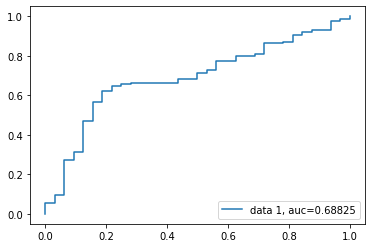

In [9]:
from sklearn import metrics
y_pred_proba = logreg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()